In [1]:
import numpy as np
import tensorflow as tf
import random as rn
from my_utils import Workout_dataset #, class_weight_dict
from my_model import make_CNN_RNN_model

import os

In [2]:
# seed 고정
os.environ['PYTHONHASHSEED'] = str(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)

In [3]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience = 5,verbose = 1,factor = 0.5) 

train_dir = './data/train'
label_dir = './data/data_y_train.csv'
test_dir = './data/test'
test_label_dir = './data/data_y_test.csv'
checkpoint_filepath = './save/cnn_gru_best.hdf5'

BATCH_SIZE = 64
valid_ratio = 4
select_fold = 0
train_patience = 30

train_loader = Workout_dataset(
    train_dir, label_dir, mode='Train',
    fold=select_fold, batch_size=BATCH_SIZE, shuffle=True, 
    augment=True, rot_prob=0.5, perm_prob=0.2)

valid_loader = Workout_dataset(
    train_dir, label_dir, mode='Valid',
    fold=select_fold, batch_size=BATCH_SIZE//valid_ratio, shuffle=True)
    #augment=True, rot_prob=0.3, perm_prob=0.1)

test_loader = Workout_dataset(
    test_dir, test_label_dir, mode='Test',
    batch_size=625, shuffle=False)


In [4]:
model = make_CNN_RNN_model(
    lr = 0.001,
    leakyrelu_alpha = 0.2,
    input_kernels = 20, # #10#, ##20##
    input_kernel_width = 3, # #3#, 5
    res_kernels = 60,# 30, #60#, 120
    res_kernel_width = 3, # #3#, 5
    res_regularize_coeff=0.01, # #0.01#, 0.1, 0.2
    res_num = 20 # ##3##, #5#, 7, 9, 11, 13
    )

model.summary()

_______________________
batch_normalization_12 (BatchNo (None, 300, 20)      80          leaky_re_lu_12[0][0]             
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 300, 10)      40          leaky_re_lu_20[0][0]             
__________________________________________________________________________________________________
gru (GRU)                       (None, 300, 40)      7440        batch_normalization[0][0]        
__________________________________________________________________________________________________
gru_4 (GRU)                     (None, 300, 40)      7440        batch_normalization_8[0][0]      
__________________________________________________________________________________________________
gru_12 (GRU)                    (None, 300, 40)      7440        batch_normalization_24[0][0]     
_____________________________________________________________________________________

In [5]:

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',min_delta=0.0001,
    patience=train_patience,verbose=1)

history = model.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=2000,
    callbacks=[save_best,early_stop,lr_scheduler])
    #class_weight=class_weight_dict(bias=1))


Epoch 1/2000
34/34 [==============================] - 67s 618ms/step - loss: 74.5748 - accuracy: 0.3644 - val_loss: 51.5738 - val_accuracy: 0.4453

Epoch 00001: val_loss improved from inf to 51.57378, saving model to ./save/cnn_gru_best.hdf5
Epoch 2/2000
34/34 [==============================] - 14s 402ms/step - loss: 36.6590 - accuracy: 0.5547 - val_loss: 26.0562 - val_accuracy: 0.4492

Epoch 00002: val_loss improved from 51.57378 to 26.05617, saving model to ./save/cnn_gru_best.hdf5
Epoch 3/2000
34/34 [==============================] - 14s 403ms/step - loss: 18.1404 - accuracy: 0.6204 - val_loss: 14.1448 - val_accuracy: 0.4570

Epoch 00003: val_loss improved from 26.05617 to 14.14476, saving model to ./save/cnn_gru_best.hdf5
Epoch 4/2000
34/34 [==============================] - 14s 408ms/step - loss: 9.4780 - accuracy: 0.6278 - val_loss: 8.8176 - val_accuracy: 0.4492

Epoch 00004: val_loss improved from 14.14476 to 8.81757, saving model to ./save/cnn_gru_best.hdf5
Epoch 5/2000
34/34 [

In [6]:

model.load_weights(checkpoint_filepath)
model.evaluate(test_loader,verbose=1)


1/1 [==============================] - 1s 1s/step - loss: 0.6402 - accuracy: 0.8512


[0.6402449011802673, 0.8511999845504761]

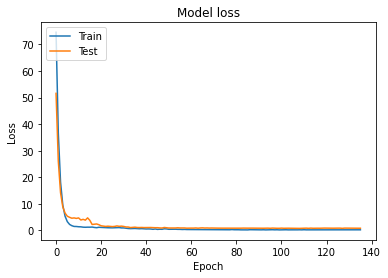

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()